# Draw dE galaxy axial ratios from an empirical distribution

We would like our simulated dwarf-elliptical galaxies to have a reasonable distribution
of axial ratios. There is an empirical distribution for Virgo Cluster dE galaxies in 
Sanchez-Janssen 2016, ApJ 820, 69 doi:10.3847/0004-637X/820/1/69. We turned this into a table for the distribution of observed axial ratios ${\rm pdf}(q)$ by digitizing the grey curve in their Figure 9 using graphclick. 

We can then use `scipy.interpolate.interp1D` to interpolate into this pdf, and then create a function that is a subclass of `scipy.stats.rv_continuous` to let us draw from this PDF. 

In [1]:
import numpy as np
from scipy import stats
from scipy import integrate
from scipy import interpolate
from astropy.table import Table
from scipy.stats import rv_continuous

In [2]:
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

In [3]:
# Create a function that returns the PDF of the axial ratio
# Empirical virgo-cluster dE distribution taken from 
# Sanchez-Janssen 2016, ApJ 820, 69 doi:10.3847/0004-637X/820/1/69
# Normalize PDF via numerical integral (it was pretty close to normalized to begin with)
# While it's not necessary to add the _cdf routine, it speeds up the rvs draws by a huge factor
class axial_ratio_pdf(rv_continuous):
    def __init__(self,**args):
        super(axial_ratio_pdf,self).__init__(a=0.,b=1.,**args)
        self.qdist = Table.read('data/sanchez-janssen_fig9.txt',format='ascii.commented_header')
        self.normalization = integrate.trapz(self.qdist['pdf'],self.qdist['q'])
        self.qfunc = interpolate.interp1d(self.qdist['q'],self.qdist['pdf'],kind='linear')
        qsamples = np.arange(0,1.01,0.01)
        cdf_samples = np.array([integrate.quad(self._pdf,0,q)[0] for q in qsamples])
        self.cfunc = interpolate.interp1d(qsamples,cdf_samples)
    def _pdf(self,q):
        return self.qfunc(q)/self.normalization
    def _cdf(self,q):
        return self.cfunc(q)

In [4]:
qpdf = axial_ratio_pdf(name='qpdf')

/Users/hcferguson/anaconda3/envs/astroconda36/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Verify that the interpolated distribution looks like the input

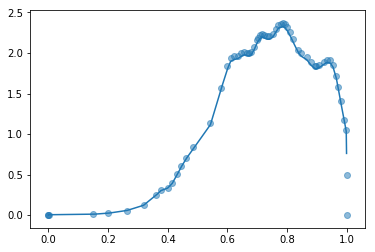

In [5]:
q = np.arange(0,1,0.001)
plt.plot(q,qpdf.pdf(q))
plt.scatter(qpdf.qdist['q'],qpdf.qdist['pdf'],alpha=0.5)

Verify that the pdf integrates to 1

In [6]:
integrate.quad(qpdf.pdf,0,1)

(1.0000343332140393, 0.0002048140500744422)

In [7]:
N=1000 # number of galaxies
g = qpdf.rvs(size=N)

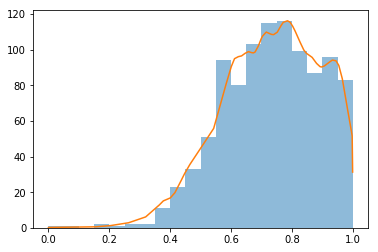

In [8]:
step=0.05
foo = plt.hist(g,np.arange(0.,1.05,step),alpha=0.5)
q = np.arange(0,1,step/100.)
plt.plot(q,N*qpdf.pdf(q)*step)